#DEEP LEARNING
##Lab 6

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torchvision

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.ReLU()
        )

        # Latent space
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        # Latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        # Decoder
        z = z.view(z.size(0), -1, 1, 1)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [9]:
class FaceMaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root=root_dir, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return img


In [10]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [11]:
# Load datasets
train_dataset = FaceMaskDataset(root_dir='/content/drive/MyDrive/Deep Learning/Face Mask Dataset/Train', transform=transform)
val_dataset = FaceMaskDataset(root_dir='/content/drive/MyDrive/Deep Learning/Face Mask Dataset/Validation', transform=transform)
test_dataset = FaceMaskDataset(root_dir='/content/drive/MyDrive/Deep Learning/Face Mask Dataset/Test', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [12]:
# VAE model
model = VAE(latent_dim=100).to(device)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.BCELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)

        data_resized = nn.functional.interpolate(data, size=(64, 64), mode='bilinear', align_corners=False)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_resized)

        recon_batch_resized = nn.functional.interpolate(recon_batch, size=(32, 32), mode='bilinear', align_corners=False)

        data_original_resized = nn.functional.interpolate(data, size=(32, 32), mode='bilinear', align_corners=False)

        loss = loss_function(recon_batch_resized, data_original_resized, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [14]:
# Validation function
def validate(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)

            data_resized = nn.functional.interpolate(data, size=(64, 64), mode='bilinear', align_corners=False)

            recon_batch, mu, logvar = model(data_resized)

            recon_batch_resized = nn.functional.interpolate(recon_batch, size=(32, 32), mode='bilinear', align_corners=False)

            data_original_resized = nn.functional.interpolate(data, size=(32, 32), mode='bilinear', align_corners=False)

            val_loss += loss_function(recon_batch_resized, data_original_resized, mu, logvar).item()

    val_loss /= len(val_loader.dataset)
    print('====> Validation set loss: {:.4f}'.format(val_loss))
    return val_loss


In [15]:
# Training loop
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, epoch)
    validate(model, val_loader)


Train Epoch: 1 [0/10010 (0%)]	Loss: 2128.415039
Train Epoch: 1 [6400/10010 (64%)]	Loss: 1895.039673
====> Epoch: 1 Average loss: 1967.7838
====> Validation set loss: 1889.4392
Train Epoch: 2 [0/10010 (0%)]	Loss: 1899.881470
Train Epoch: 2 [6400/10010 (64%)]	Loss: 1849.332520
====> Epoch: 2 Average loss: 1850.3387
====> Validation set loss: 1831.3526
Train Epoch: 3 [0/10010 (0%)]	Loss: 1798.451416
Train Epoch: 3 [6400/10010 (64%)]	Loss: 1799.640015
====> Epoch: 3 Average loss: 1808.1542
====> Validation set loss: 1797.1389
Train Epoch: 4 [0/10010 (0%)]	Loss: 1822.839844
Train Epoch: 4 [6400/10010 (64%)]	Loss: 1785.364746
====> Epoch: 4 Average loss: 1787.9404
====> Validation set loss: 1783.9627
Train Epoch: 5 [0/10010 (0%)]	Loss: 1811.542847
Train Epoch: 5 [6400/10010 (64%)]	Loss: 1748.982910
====> Epoch: 5 Average loss: 1777.5183
====> Validation set loss: 1773.8571
Train Epoch: 6 [0/10010 (0%)]	Loss: 1771.327759
Train Epoch: 6 [6400/10010 (64%)]	Loss: 1770.454468
====> Epoch: 6 Avera

In [16]:
# Test function
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)

            data_resized = nn.functional.interpolate(data, size=(64, 64), mode='bilinear', align_corners=False)

            recon_batch, mu, logvar = model(data_resized)

            recon_batch_resized = nn.functional.interpolate(recon_batch, size=(32, 32), mode='bilinear', align_corners=False)

            data_original_resized = nn.functional.interpolate(data, size=(32, 32), mode='bilinear', align_corners=False)

            test_loss += loss_function(recon_batch_resized, data_original_resized, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss


In [17]:
# Test the model
test(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'vae_model.pth')


====> Test set loss: 1782.9436


In [18]:
# Load the saved model
model = VAE(latent_dim=100).to(device)
model.load_state_dict(torch.load('vae_model.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=4096, out_features=100, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=100, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [19]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


In [20]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch)
    val_loss = validate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


Train Epoch: 1 [0/10010 (0%)]	Loss: 1725.727051
Train Epoch: 1 [6400/10010 (64%)]	Loss: 1753.884766
====> Epoch: 1 Average loss: 1756.9591
====> Validation set loss: 1757.7246
Train Epoch: 2 [0/10010 (0%)]	Loss: 1782.128540
Train Epoch: 2 [6400/10010 (64%)]	Loss: 1765.720825
====> Epoch: 2 Average loss: 1757.0159
====> Validation set loss: 1757.5050
Train Epoch: 3 [0/10010 (0%)]	Loss: 1740.824097
Train Epoch: 3 [6400/10010 (64%)]	Loss: 1736.722046
====> Epoch: 3 Average loss: 1757.0116
====> Validation set loss: 1757.3409
Train Epoch: 4 [0/10010 (0%)]	Loss: 1725.972900
Train Epoch: 4 [6400/10010 (64%)]	Loss: 1775.172852
====> Epoch: 4 Average loss: 1757.0568
====> Validation set loss: 1757.3855
Train Epoch: 5 [0/10010 (0%)]	Loss: 1770.776367
Train Epoch: 5 [6400/10010 (64%)]	Loss: 1757.770630
====> Epoch: 5 Average loss: 1757.1038
====> Validation set loss: 1757.5921
Train Epoch: 6 [0/10010 (0%)]	Loss: 1772.301880
Train Epoch: 6 [6400/10010 (64%)]	Loss: 1776.978516
====> Epoch: 6 Avera

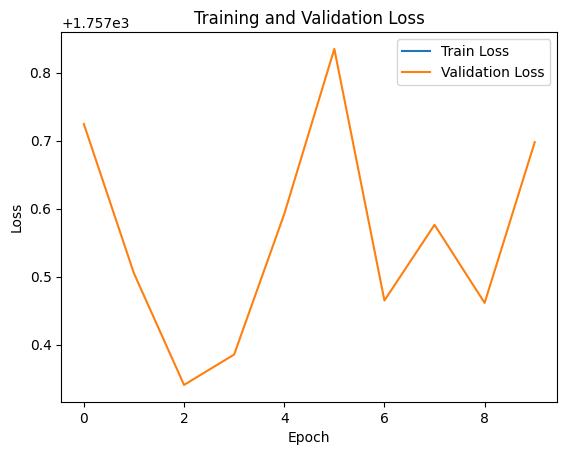

In [24]:
plot_losses(train_losses, val_losses)


In [25]:
# Compare reconstruction on test set
def compare_reconstructions(model, test_loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            if i >= num_samples:
                break
            data = data.to(device)
            recon_batch, _, _ = model(data)

            recon_batch_resized = nn.functional.interpolate(recon_batch, size=(data.shape[2], data.shape[3]), mode='bilinear', align_corners=False)

            comparison = torch.cat([data[:num_samples], recon_batch_resized[:num_samples]])
            comparison = comparison.cpu()
            grid = torchvision.utils.make_grid(comparison, nrow=num_samples)
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.show()


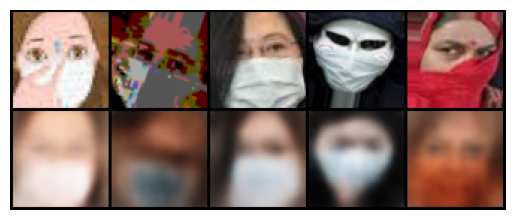

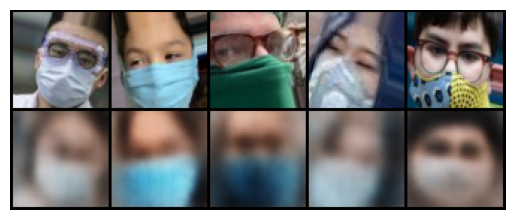

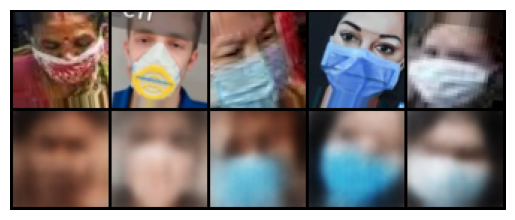

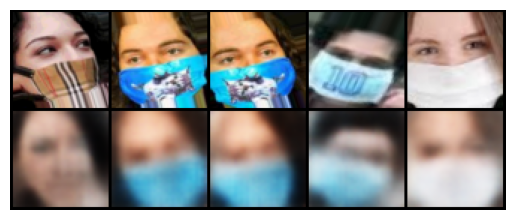

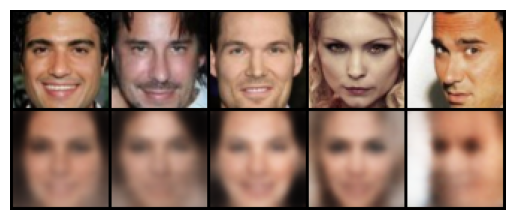

In [26]:
compare_reconstructions(model, test_loader)


In [27]:
def sample_latent_space(model, num_samples=5):
    model.eval()
    with torch.no_grad():
        for _ in range(num_samples):
            latent_sample = torch.randn(1, model.latent_dim, 1, 1).to(device)
            reconstructed_img = model.decoder(latent_sample)
            reconstructed_img = reconstructed_img.squeeze().cpu()
            plt.imshow(reconstructed_img.permute(1, 2, 0))
            plt.axis('off')
            plt.show()


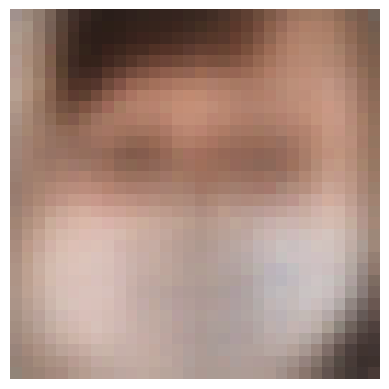

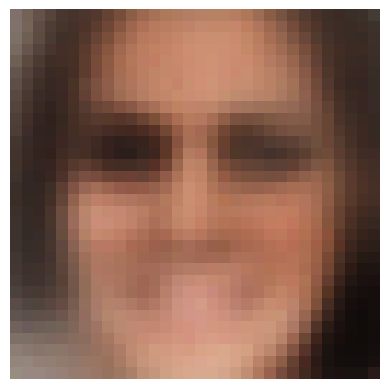

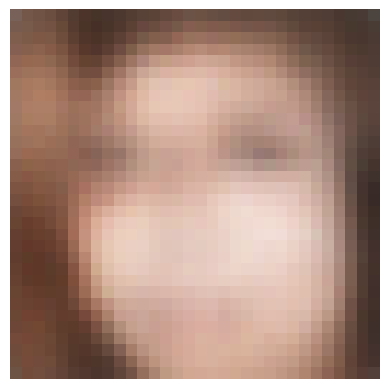

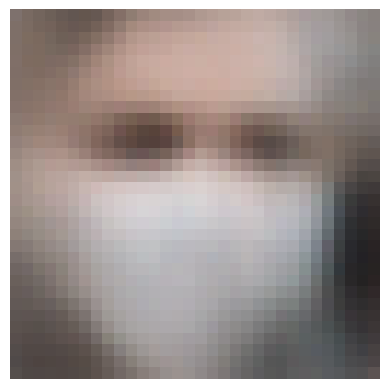

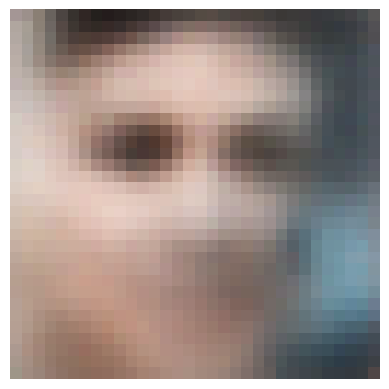

In [28]:
sample_latent_space(model)

In [29]:
def plot_tsne(vae_model, ae_model, test_loader):
    vae_embeddings = []
    ae_embeddings = []
    labels = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            vae_recon_batch, vae_mu, vae_logvar = vae_model(data)
            ae_recon_batch = ae_model(data)
            vae_embeddings.append(vae_mu.cpu().numpy())
            ae_embeddings.append(ae_recon_batch.cpu().numpy())
            labels.extend([0] * len(data))

    vae_embeddings = np.concatenate(vae_embeddings, axis=0)
    ae_embeddings = np.concatenate(ae_embeddings, axis=0)
    labels = np.array(labels)

    # Perform t-SNE
    tsne = TSNE(n_components=2)
    vae_tsne_embedded = tsne.fit_transform(vae_embeddings)
    ae_tsne_embedded = tsne.fit_transform(ae_embeddings)

    # Plot t-SNE
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(vae_tsne_embedded[:, 0], vae_tsne_embedded[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title('VAE Latent Space (t-SNE)')
    plt.subplot(1, 2, 2)
    plt.scatter(ae_tsne_embedded[:, 0], ae_tsne_embedded[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title('Autoencoder Latent Space (t-SNE)')
    plt.show()


In [35]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent_representation = self.encoder(x)
        reconstructed_output = self.decoder(latent_representation)
        return reconstructed_output


In [36]:
autoencoder = Autoencoder()

In [37]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


In [60]:
# Training loop
def train(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 100 == 99:
                print('[Epoch %d, Batch %5d] Loss: %.3f' %
                      (epoch, batch_idx + 1, running_loss / 100))
                running_loss = 0.0


In [61]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
train(autoencoder, train_loader, optimizer, criterion, num_epochs=10)


[Epoch 1, Batch   100] Loss: 0.027
[Epoch 2, Batch   100] Loss: 0.006
[Epoch 3, Batch   100] Loss: 0.004
[Epoch 4, Batch   100] Loss: 0.003
[Epoch 5, Batch   100] Loss: 0.003
[Epoch 6, Batch   100] Loss: 0.003
[Epoch 7, Batch   100] Loss: 0.002
[Epoch 8, Batch   100] Loss: 0.002
[Epoch 9, Batch   100] Loss: 0.002
[Epoch 10, Batch   100] Loss: 0.002


In [72]:
def interpolate(model, test_loader, num_interpolations=10):
    model.eval()

    for batch in test_loader:
        data1, data2 = batch[:2]
        data1, data2 = data1.to(device), data2.to(device)

        z1, _ = model.encoder(data1)
        z2, _ = model.encoder(data2)

        for t in np.linspace(0, 1, num_interpolations):
            interpolated_z = z1 * (1 - t) + z2 * t

            interpolated_img = model.decoder(interpolated_z)

            interpolated_img = interpolated_img.squeeze().cpu()
            plt.imshow(interpolated_img.permute(1, 2, 0))
            plt.axis('off')
            plt.show()


In [73]:
# Evaluate performance on a classification task
def evaluate_classification_task(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            latent_representations, _ = model.encoder(images)
            outputs = classifier(latent_representations)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy on the classification task: {:.2f}%'.format(accuracy))
    return accuracy


In [76]:
latent_dim = 100

model = VAE(latent_dim=latent_dim)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
